In [1]:
# !pip install graphviz pydot
import time
import random
import numpy as np
from copy import deepcopy
from collections import defaultdict
from graphviz import Digraph  # For state-transition diagrams

# General Components 

> Adapted from Lab 5 and [Udacity's Deep Reinforcement Learning Nanodegree](https://github.com/udacity/deep-reinforcement-learning/blob/master/dynamic-programming/Dynamic_Programming_Solution.ipynb) program, but generalized for stochastic r(s,a,s') and finite horizon

## 1. MDP class

In [2]:
class MDP: # For state-specific actions
    def __init__(self, states, actions_dict, transition_probs, rewards, gamma=1.0, horizon=10, terminal_states=None):
        ''' Initialize the finite horizon MDP.
        - states: List of all states (str or any hashable).
        - actions_dict: Dict {s: [actions]} mapping states to their available actions.
        - transition_probs: Dict {s: {a: {s': prob}}} where sum_{s'} prob = 1 (stochastic).
        - rewards: Dict {s: {a: {s': reward}}} for r(s,a,s') (stochastic rewards possible).
        - gamma: Discount factor (1.0 for undiscounted finite horizon).
        - horizon: Finite time steps H (episode length limit).
        - terminal_states: List of absorbing states (e.g., ['Destination']).
        '''
        self.states = states
        self.actions_dict = actions_dict
        self.transition_probs = transition_probs
        self.rewards = rewards
        self.gamma = gamma
        self.horizon = horizon
        self.terminal_states = terminal_states or []
        
        for s in transition_probs: # Ensure all probs sum to 1, rewards defined
            for a in transition_probs[s]:
                assert abs(sum(transition_probs[s][a].values()) - 1.0) < 1e-6, f'Probs not sum 1 for {s},{a}'

    def get_actions(self, state):
        return self.actions_dict.get(state, [])

    def is_terminal(self, state): # Check if state is terminal (absorbing, no actions, value based on reward)
        return state in self.terminal_states

    def draw_state_diagram(self, rankdir='LR', size=12, show_legend=True, saved_name=None):
        dot = Digraph(comment='Simplified MDP Diagram', graph_attr={'rankdir': rankdir, 'nodesep': '0.2', 'fontname': 'Arial Bold', 'fontsize': '16', 'size': f'{size}'})
        clusters = {'safe': [], 'mid': [], 'risky': []} # Dynamically collect states per cluster
        
        def get_cluster(state):
            '''
            Heuristically categorize state for clustering based on keywords.
            - Safe: Low-risk/progress states (e.g., 'Clear', 'Quiet', 'Optimal').
            - Mid: Transitional/moderate (e.g., 'Busy', 'Ped', 'Mixed').
            - Risky: High-cost/failure (e.g., 'Jam', 'Obstacle', 'Gridlock').
            '''
            safe_keywords = ['Clear', 'Quiet', 'Optimal']
            mid_keywords = ['Behind', 'School', 'Ped', 'Intersection', 'Mixed', 'Busy', 'Crowd', 'Construction', 'Event']
            risky_keywords = ['TrafficJam', 'Obstacle', 'Gridlock', 'Destination']
            if any(k.lower() in state.lower() for k in safe_keywords): return 'safe'
            if any(k.lower() in state.lower() for k in mid_keywords): return 'mid'
            if any(k.lower() in state.lower() for k in risky_keywords): return 'risky'
    
        for s in self.states:
            cluster = get_cluster(s)
            clusters[cluster].append(s)
            
        if clusters['safe']:
            with dot.subgraph(name='cluster_safe') as c:
                c.attr(style='filled', fillcolor='lightgreen', label='Safe States')
                for s in clusters['safe']:
                    c.node(s, s, shape='ellipse', style='filled', fillcolor='forestgreen', fontcolor='white', fontsize='16', fontname='Arial Bold')

        if clusters['mid']:
            with dot.subgraph(name='cluster_mid') as c:
                c.attr(style='filled', fillcolor='lightyellow', label='Mid States')
                for s in clusters['mid']:
                    c.node(s, s, shape='ellipse', style='filled', fillcolor='gold', fontcolor='black', fontsize='16', fontname='Arial Bold')

        if clusters['risky']:
            with dot.subgraph(name='cluster_risky') as c:
                c.attr(style='filled', fillcolor='lightpink', label='Risky/Terminal')
                for s in clusters['risky']:
                    color = 'crimson' if self.is_terminal(s) else 'orange'
                    shape = 'doublecircle' if self.is_terminal(s) else 'ellipse'
                    c.node(s, s, shape=shape, style='filled', fillcolor=color, fontcolor='white', fontsize='16', fontname='Arial Bold')

        for s in self.states:
            for a in self.get_actions(s):
                for s_next, p in self.transition_probs.get(s, {}).get(a, {}).items():
                    if p <= 0: continue
                    r = self.rewards.get(s, {}).get(a, {}).get(s_next, 0.0)
                    label = f'{a}\\np={p:.2f}, r={r}'
                    edge_color = 'dodgerblue' if r >= 0 else 'firebrick'
                    style = 'solid' if p >= 0.5 else 'dashed'
                    dot.edge(s, s_next, label=label, color=edge_color, fontname='Arial', fontsize='14', penwidth='1.5' if p >= 0.5 else '1.0', style=style)
                        
        if show_legend:
            with dot.subgraph(name='cluster_legend') as leg: # Add Legend Subgraph
                leg.attr(label='Legend', labelfontsize='16', style='dashed', color='black', fontname='Arial Bold') 
                # Nodes for state colors
                leg.node('leg_safe'    , 'Safe'    , shape='ellipse', style='filled', fillcolor='forestgreen', fontcolor='white', fontsize='16', fontname='Arial Bold')
                leg.node('leg_mid'     , 'Mid'     , shape='ellipse', style='filled', fillcolor='gold'       , fontcolor='black', fontsize='16', fontname='Arial Bold')
                leg.node('leg_risky'   , 'Risky'   , shape='ellipse', style='filled', fillcolor='orange'     , fontcolor='white', fontsize='16', fontname='Arial Bold')
                leg.node('leg_terminal', 'Terminal', shape='circle' , style='filled', fillcolor='crimson'    , fontcolor='white', fontsize='16', fontname='Arial Bold')
                # Edges for edge meanings
                leg.edge('leg_safe'    , 'leg_mid'     , label='Positive Reward (r >= 0)' , color='dodgerblue', fontsize='14', fontname='Arial', penwidth='1.5')
                leg.edge('leg_mid'     , 'leg_risky'   , label='Negative Reward (r < 0)', color='firebrick' , fontsize='14', fontname='Arial', penwidth='1.5')
                leg.edge('leg_risky'   , 'leg_terminal', label='High Prob (p >= 0.5)'    , style='solid'     , fontsize='14', fontname='Arial', penwidth='1.5')
                leg.edge('leg_terminal', 'leg_safe'    , label='Low Prob (p < 0.5)'      , style='dashed'    , fontsize='14', fontname='Arial', penwidth='1.0')

        if saved_name: dot.render(saved_name, format='png', view=False)
        return dot

## 2. Value Iteration (finite + infinite horizon)

In [3]:
def finite_value_iteration(mdp, theta=1e-3): # Backward Dynamic Programming (Backward Induction) with gamma = 1
    ''' Compute time-dependent optimal value function V[h][s] for h=1 to H.
    The theta in this finite implementation is just to check convergence when not using horizon as stopping criterion, not for breaking the loop 
    V[0][s] = 0 for non-terminals, or terminal reward.
    For each h=1 to H:
        V[h][s] = max_a sum_{s'} P(s'|s,a) [ R(s,a,s') + gamma * V[h-1][s'] ]
    Returns: V (dict {h: {s: value}}), policy (dict {h: {s: best_a}}) extracted at h=H.
    '''
    V = {0: {s: 0.0 for s in mdp.states}} # Base case at h=0
    policy = {
        h: {s: {a: 0.0 for a in mdp.get_actions(s)} for s in mdp.states if not mdp.is_terminal(s)} 
        for h in range(1, mdp.horizon + 1)
    }
    deltas = []  # Track max delta per h. 
    
    for h in range(1, mdp.horizon + 1):
        V[h] = {}
        max_delta = 0.0
        
        for s in mdp.states:
            if mdp.is_terminal(s): # Terminal: Value is 0 (or self-reward if any), absorbing
                V[h][s] = 0.0  # Assuming no ongoing reward
                continue
            
            # Computes the value of a state using the Bellman optimality equation
            best_action_value, best_action = float('-inf'), None  # Initialize the best action and its corresponding value for this state
            for a in mdp.get_actions(s): # Iterate over each action available in the current state
                expected_value = 0.0 # Initialize the expected value for this action (corresponding to the summation term in the Bellman equation)
                for s_next in mdp.states: # Calculate the expected value for the action by summing over all possible next states
                    p = mdp.transition_probs.get(s, {}).get(a, {}).get(s_next, 0.0) # Transition probability from 'state' to 'next_state' given 'action' (P(s' | s, a))
                    r = mdp.rewards.get(s, {}).get(a, {}).get(s_next, 0.0) # Immediate reward for taking 'action' in 'state' (approximation for R(s, a, s'))
                    expected_value += p * (r + mdp.gamma * V[h-1][s_next]) # Update the action's expected value using Bellman equation components
                    
                if expected_value > best_action_value: # Update best action if this action's value is higher
                    best_action_value = expected_value # Highest expected value among all actions, which corresponds to the max_a operation in Bellman equation
                    best_action = a # Best action leading to the highest expected value

            V[h][s] = best_action_value
            max_delta = max(max_delta, abs(V[h][s] - V[h-1][s]))
            for a in policy[h][s]: # Deterministic policy at each h: prob 1 for best, 0 others
                policy[h][s][a] = 1.0 if a == best_action else 0.0
        deltas.append(max_delta)
        
    # Find first h where delta < theta (would converge if infinite)
    conv_h = next((i + 1 for i, d in enumerate(deltas) if d < theta), mdp.horizon)  # If none, full H
    print(f'Finite Value Iteration: Would converge at h={conv_h} if no horizon (delta < {theta})')
    return V, policy, deltas, conv_h

In [4]:
def infinite_value_iteration(mdp, gamma=0.99, theta=1e-3): # (gamma < 1)
    V = {s: 0.0 for s in mdp.states}
    policy = {s: {a: 0.0 for a in mdp.get_actions(s)} for s in mdp.states if not mdp.is_terminal(s)}
    iteration = 0
    
    while True:
        iteration += 1
        delta = 0.0
        new_V = deepcopy(V)
        
        for s in mdp.states:
            if mdp.is_terminal(s): continue
            
            # Computes the value of a state using the Bellman optimality equation
            best_action_value, best_action = float('-inf'), None # Initialize the best action and its corresponding value for this state
            for a in mdp.get_actions(s): # Iterate over each action available in the current state
                expected_value = 0.0 # Initialize the expected value for this action
                for s_next in mdp.states: # Calculate the expected value for the action by summing over all possible next states
                    p = mdp.transition_probs.get(s, {}).get(a, {}).get(s_next, 0.0) # Transition probability from 'state' to 'next_state' given 'action' (P(s' | s, a))
                    r = mdp.rewards.get(s, {}).get(a, {}).get(s_next, 0.0) # Immediate reward for taking 'action' in 'state' (approximation for R(s, a, s'))
                    expected_value += p * (r + gamma * V[s_next]) # Update the action's expected value using Bellman equation components
                
                if expected_value > best_action_value: # Update best action if this action's value is higher
                    best_action_value = expected_value # Highest expected value among all actions, which corresponds to the max_a operation in Bellman equation
                    best_action = a # Best action leading to the highest expected value
                    
            new_V[s] = best_action_value
            delta = max(delta, abs(new_V[s] - V[s]))
            for a in policy[s]: # Deterministic policy: prob 1 for best, 0 others
                policy[s][a] = 1.0 if a == best_action else 0.0
                
        V = new_V # Update the value function for the next iteration
        if delta < theta: break # Convergence Check
    return V, policy, iteration

## 3. Policy Iteration (finite + infinite horizon)

### 3.1. Policy Evaluation (for stochastic or deterministic policy)

In [5]:
def finite_policy_evaluation(mdp, policy):
    ''' Evaluate a (possibly stochastic) policy over the finite horizon.
    Policy can be deterministic {h: {s: a}} or stochastic {h: {s: {a: prob}}}.
    Compute V_pi[h][s] backward:
    V_pi[0][s] = 0
    V_pi[h][s] = sum_a pi(a|s,h) sum_{s'} P(s'|s,a) [ R(s,a,s') + gamma * V_pi[h-1][s'] ]
    Returns: V_pi {h: {s: value}}
    '''
    V = {0: {s: 0.0 for s in mdp.states}}
    for h in range(1, mdp.horizon + 1):
        V[h] = {}
        
        # Update each state's value based on the Bellman expectation equation
        for s in mdp.states: # Select a state from list of all states
            if mdp.is_terminal(s):
                V[h][s] = 0.0
                continue
            state_value = 0.0
            
            # Handle stochastic or deterministic policy
            if isinstance(policy[h][s], dict):  # Stochastic: {a: prob}
                for a, pi_a in policy[h][s].items():
                    for s_next in mdp.states:
                        p = mdp.transition_probs.get(s, {}).get(a, {}).get(s_next, 0.0)
                        r = mdp.rewards.get(s, {}).get(a, {}).get(s_next, 0.0)
                        state_value += pi_a * p * (r + mdp.gamma * V[h-1][s_next])
            # else:  # Given the deterministic policy, we directly get the action for the state
            #     a = policy[h][s] # Following the given policy select the next action for the state
            #     for s_next in mdp.states:
            #         p = mdp.transition_probs.get(s, {}).get(a, {}).get(s_next, 0.0)
            #         r = mdp.rewards.get(s, {}).get(a, {}).get(s_next, 0.0)
            #         state_value += p * (r + mdp.gamma * V[h-1][s_next]) # Update the state value for the action given the policy
            V[h][s] = state_value
    return V

In [6]:
def infinite_policy_evaluation(mdp, policy, gamma=0.99, theta=1e-3): # Eval (infinite, iterative until delta < theta)
    V = {s: 0.0 for s in mdp.states}
    while True:
        delta = 0.0
        new_V = deepcopy(V)
        
        for s in mdp.states:
            if mdp.is_terminal(s): continue
            state_value = 0.0
            
            # Handle stochastic or deterministic policy
            if isinstance(policy[s], dict):  # Stochastic: {a: prob}
                for a, pi_a in policy[s].items():
                    for s_next in mdp.states:
                        p = mdp.transition_probs.get(s, {}).get(a, {}).get(s_next, 0.0)
                        r = mdp.rewards.get(s, {}).get(a, {}).get(s_next, 0.0)
                        state_value += pi_a * p * (r + mdp.gamma * V[s_next])
            else:  # Given the deterministic policy, we directly get the action for the state
                a = policy[s] # Following the given policy select the next action for the state
                for s_next in mdp.states:
                    p = mdp.transition_probs.get(s, {}).get(a, {}).get(s_next, 0.0)
                    r = mdp.rewards.get(s, {}).get(a, {}).get(s_next, 0.0)
                    state_value += p * (r + mdp.gamma * V[s_next]) # Update the state value for the action given the policy

            new_V[s] = state_value
            delta = max(delta, abs(new_V[s] - V[s]))
            
        V = new_V # Update the value function for the next iteration
        if delta < theta: break
    return V

### 3.2. Policy Improvement

In [7]:
def finite_policy_improvement(mdp, V): # (Greedy det., but in stochastic format)
    '''
    Improve policy greedily based on V[h][s].
    For each h, s: pi'[h][s] = argmax_a sum_{s'} P [ R + gamma V[h-1][s'] ]
    Returns deterministic policy {h: {s: a}}
    '''
    policy = {
        h: {s: {a: 0.0 for a in mdp.get_actions(s)} for s in mdp.states if not mdp.is_terminal(s)} 
        for h in range(1, mdp.horizon + 1)
    }
    for h in range(1, mdp.horizon + 1):
        for s in mdp.states:
            if mdp.is_terminal(s): continue
            Q = {} # Action-value function to evaluate each action's expected value
            for a in mdp.get_actions(s):
                expected_value = 0.0
                for s_next in mdp.states: # Calculate the expected value of this action over all next possible states
                    p = mdp.transition_probs.get(s, {}).get(a, {}).get(s_next, 0.0)
                    r = mdp.rewards.get(s, {}).get(a, {}).get(s_next, 0.0)
                    expected_value += p * (r + mdp.gamma * V[h-1][s_next])
                Q[a] = expected_value

            best_action = max(Q, key=Q.get) # Select the action with the highest expected value
            for a in policy[h][s]: # Deterministic policy at each h: prob 1 for best, 0 others
                policy[h][s][a] = 1.0 if a == best_action else 0.0
    return policy

In [8]:
def infinite_policy_improvement(mdp, V, gamma=0.99):
    policy = {
        s: {a: 0.0 for a in mdp.get_actions(s)} 
        for s in mdp.states if not mdp.is_terminal(s)
    }
    for s in mdp.states:
        if mdp.is_terminal(s): continue
        Q = {} # Action-value function to evaluate each action's expected value
        for a in mdp.get_actions(s):
            expected_val = 0.0
            for s_next in mdp.states: # Calculate the expected value of this action over all next possible states
                p = mdp.transition_probs.get(s, {}).get(a, {}).get(s_next, 0.0)
                r = mdp.rewards.get(s, {}).get(a, {}).get(s_next, 0.0)
                expected_val += p * (r + gamma * V[s_next])
            Q[a] = expected_val
            
        best_action = max(Q, key=Q.get) # Select the action with the highest expected value
        for a in policy[s]: # Deterministic policy: prob 1 for best, 0 others
            policy[s][a] = 1.0 if a == best_action else 0.0
    return policy

### 3.3. Alternates evaluation and improvement until stable

In [9]:
def finite_policy_iteration(mdp):
    '''
    Policy iteration for finite horizon: Start with random stochastic policy.
    Repeat: Evaluate policy to get V_pi, improve to new_policy.
    Stop if policy stable.
    Since time-dependent, compare policies per h.
    '''
    policy = { # Stochastic init: uniform over available actions per s
        h: {
            s: {a: 1.0 / len(mdp.get_actions(s)) for a in mdp.get_actions(s)} 
            for s in mdp.states if not mdp.is_terminal(s)
        } for h in range(1, mdp.horizon + 1)
    }
    iteration = 0
    while True:
        iteration += 1
        V = finite_policy_evaluation(mdp, policy)
        new_policy = finite_policy_improvement(mdp, V)
        if all( # Check stability: probs match
            all(abs(new_policy[h][s][a] - policy[h][s][a]) < 1e-6 for a in policy[h][s]) 
            for h in range(1, mdp.horizon + 1) for s in policy[h]
        ): break
        policy = deepcopy(new_policy) # Update the policy for the next iteration

    print(f'Finite Policy Iteration: Converged after {iteration} iterations (policy stable)')
    return V, policy, iteration

In [10]:
def infinite_policy_iteration(mdp, gamma=0.99, theta=1e-3):
    policy = { # Stochastic init: uniform over available actions per s
        s: {a: 1.0 / len(mdp.get_actions(s)) for a in mdp.get_actions(s)} 
        for s in mdp.states if not mdp.is_terminal(s)
    }
    iteration = 0
    while True:
        iteration += 1
        V = infinite_policy_evaluation(mdp, policy, gamma, theta)
        new_policy = infinite_policy_improvement(mdp, V, gamma)
        
        if all( # Check stable
            all(abs(new_policy[s][a] - policy[s][a]) < 1e-6 for a in policy[s]) 
            for s in policy
        ): break
        policy = deepcopy(new_policy)
    return V, policy, iteration

## 4. Experiment Functions

In [11]:
def simulate_mdp(mdp, policy, start_state, num_episodes=1000, is_finite=True):
    ''' Simulate the environment to compute the average reward over a number of episodes.
    
    Parameters:
    - mdp: The MDP environment.
    - policy: The policy to follow.
    - start_state: The state to start the simulation from.
    - num_episodes: The number of episodes to simulate.
    - is_finite: Whether the MDP is finite or infinite.

    Returns: The average reward accumulated per episode over the specified number of episodes.
    '''
    total_rewards = 0.0
    for _ in range(num_episodes):
        state = start_state
        episode_reward = 0.0
        step = 0
        while True:
            step += 1
            if mdp.is_terminal(state) or (is_finite and step > mdp.horizon): 
                break # Each episode runs up to horizon steps or terminal
            
            if is_finite: # Simulate episodes using the (time-dependent) policy to compute average undiscounted reward.
                h = min(step, mdp.horizon) 
                pol = policy[h][state]
            else: # For infinite, policy is {s: {a:p}}, no h
                pol = policy[state] # drop h-dependence
            
            # Sample action from stochastic policy
            actions = list(pol.keys())
            probs = list(pol.values())
            a = np.random.choice(actions, p=probs)

            # Sample next state
            next_states = list(mdp.transition_probs[state][a].keys())
            trans_probs = list(mdp.transition_probs[state][a].values())
            next_state = np.random.choice(next_states, p=trans_probs)
            
            # Get reward
            r = mdp.rewards[state][a][next_state]
            episode_reward += r * (mdp.gamma ** (step-1)) if not is_finite else r  # Discount for infinite
            state = next_state
        total_rewards += episode_reward
    return total_rewards / num_episodes

In [12]:
def compare_algorithms(mdp, start_state, theta=1e-3, inf_gamma=0.9, include_inf=True):
    # Finite Value Iteration
    start_time = time.time()
    VI_V, VI_policy, VI_deltas, VI_conv_h = finite_value_iteration(mdp, theta)
    VI_time = time.time() - start_time
    VI_avg_reward = simulate_mdp(mdp, VI_policy, start_state, is_finite=True)

    # Finite Policy Iteration
    start_time = time.time()
    PI_V, PI_policy, PI_iteration = finite_policy_iteration(mdp)
    PI_time = time.time() - start_time
    PI_avg_reward = simulate_mdp(mdp, PI_policy, start_state, is_finite=True)

    if include_inf:
        # Infinite VI
        mdp_inf = deepcopy(mdp)  # Copy for inf, set gamma
        mdp_inf.gamma = inf_gamma
        start_time = time.time()
        inf_VI_V, inf_VI_policy, inf_VI_iteration = infinite_value_iteration(mdp_inf, inf_gamma, theta)
        inf_VI_time = time.time() - start_time
        inf_VI_avg_reward = simulate_mdp(mdp_inf, inf_VI_policy, start_state, is_finite=False)

        # Infinite PI
        start_time = time.time()
        inf_PI_V, inf_PI_policy, inf_PI_iteration = infinite_policy_iteration(mdp_inf, inf_gamma, theta)
        inf_PI_time = time.time() - start_time
        inf_PI_avg_reward = simulate_mdp(mdp_inf, inf_PI_policy, start_state, is_finite=False)

    # Differences between finite VI and PI at horizon H
    value_diff = sum(abs(VI_V[mdp.horizon][s] - PI_V[mdp.horizon][s]) for s in mdp.states)
    policy_diff = sum(sum(abs(
        VI_policy[mdp.horizon][s][a] - PI_policy[mdp.horizon][s][a]
    ) for a in mdp.get_actions(s)) for s in mdp.states if not mdp.is_terminal(s))
    
    # policy_diff = sum(sum(abs(
    #     list(VI_policy[mdp.horizon][s].values())[list(VI_policy[mdp.horizon][s].keys()).index(a)] - 
    #     list(PI_policy[mdp.horizon][s].values())[list(PI_policy[mdp.horizon][s].keys()).index(a)]
    # ) for a in mdp.get_actions(s)) for s in mdp.states if not mdp.is_terminal(s))

    results = {
        'Finite Value Diff': value_diff,
        'Finite Policy Diff': policy_diff,
        'Finite Value Iteration': {
            'Time': VI_time, 
            'Conv Step (delta < theta)': VI_conv_h,
            'Avg Reward': VI_avg_reward, 
            'Value Function (at H)': VI_V[mdp.horizon], 
            'Policy (at H)': {s: {a: p for a, p in policy.items() if p > 0} for s, policy in VI_policy[mdp.horizon].items()}, 
        },
        'Finite Policy Iteration': {
            'Time': PI_time, 
            'Iters to Stable': PI_iteration,
            'Avg Reward': PI_avg_reward, 
            'Value Function (at H)': PI_V[mdp.horizon], 
            'Policy (at H)': {s: {a: p for a, p in policy.items() if p > 0} for s, policy in PI_policy[mdp.horizon].items()}, 
        }
    }
    if include_inf:
        results[f'Infinite Value Iteration (gamma={inf_gamma})'] = {
            'Time': inf_VI_time, 
            'Iters to Conv': inf_VI_iteration, 
            'Avg Reward (disc)': inf_VI_avg_reward,
            'Value Function': inf_VI_V, 
            'Policy': {s: {a: p for a, p in policy.items() if p > 0} for s, policy in inf_VI_policy.items()}, 
        }
        results[f'Infinite Policy Iteration (gamma={inf_gamma})'] = {
            'Time': inf_PI_time, 
            'Iters to Stable': inf_PI_iteration, 
            'Avg Reward (disc)': inf_PI_avg_reward,
            'Value Function': inf_PI_V, 
            'Policy': {s: {a: p for a, p in policy.items() if p > 0} for s, policy in inf_PI_policy.items()}, 
        }
    return results

# Scenario – 1: Safe Navigation of an Autonomous Vehicle

In [13]:
states = ['ClearRoad', 'BehindCar', 'SchoolZone', 'PedCrossing', 'TrafficJam', 'Intersection', 'Obstacle', 'Destination']
terminal_states = ['Destination']
actions_dict = {
    'ClearRoad': ['Maintain', 'Accelerate', 'Decelerate', 'ChangeLane'],
    'BehindCar': ['Decelerate', 'ChangeLane', 'Stop'],
    'SchoolZone': ['Maintain', 'Decelerate', 'Stop'],  # No Accelerate
    'PedCrossing': ['Decelerate', 'Stop'],
    'TrafficJam': ['Maintain', 'ChangeLane', 'Stop'],
    'Intersection': ['Maintain', 'Decelerate', 'ChangeLane'],
    'Obstacle': ['Decelerate', 'ChangeLane', 'Stop'],
    'Destination': ['Stay']
}
transition_probs = {
    'ClearRoad': {
        'Maintain': {'SchoolZone': 0.7, 'PedCrossing': 0.3},
        'Accelerate': {'SchoolZone': 0.6, 'Obstacle': 0.4},
        'Decelerate': {'BehindCar': 0.5, 'SchoolZone': 0.5},
        'ChangeLane': {'Intersection': 0.8, 'TrafficJam': 0.2}
    },
    'BehindCar': {
        'Decelerate': {'SchoolZone': 0.6, 'PedCrossing': 0.4},
        'ChangeLane': {'TrafficJam': 0.5, 'Intersection': 0.5},
        'Stop': {'Intersection': 1.0}
    },
    'SchoolZone': {
        'Maintain': {'PedCrossing': 0.6, 'Obstacle': 0.4},
        'Decelerate': {'Intersection': 0.7, 'PedCrossing': 0.3},
        'Stop': {'Intersection': 1.0}
    },
    'PedCrossing': {
        'Decelerate': {'Destination': 0.7, 'Obstacle': 0.3},
        'Stop': {'Destination': 1.0}
    },
    'TrafficJam': {
        'Maintain': {'Obstacle': 0.4, 'Intersection': 0.6},
        'ChangeLane': {'Destination': 0.6, 'Obstacle': 0.4},
        'Stop': {'Destination': 1.0}
    },
    'Intersection': {
        'Maintain': {'Destination': 0.6, 'TrafficJam': 0.4},
        'Decelerate': {'Destination': 0.8, 'Obstacle': 0.2},
        'ChangeLane': {'Destination': 0.7, 'PedCrossing': 0.3}
    },
    'Obstacle': {
        'Decelerate': {'Intersection': 0.6, 'TrafficJam': 0.4},
        'ChangeLane': {'Destination': 0.5, 'ClearRoad': 0.5},
        'Stop': {'Destination': 1.0}
    },
    'Destination': {
        'Stay': {'Destination': 1.0}
    }
}
rewards = {
    'ClearRoad': {
        'Maintain': {'SchoolZone': 10, 'PedCrossing': -10},
        'Accelerate': {'SchoolZone': 15, 'Obstacle': -50},
        'Decelerate': {'BehindCar': -20, 'SchoolZone': 5},
        'ChangeLane': {'Intersection': 20, 'TrafficJam': -30}
    },
    'BehindCar': {
        'Decelerate': {'SchoolZone': 10, 'PedCrossing': 5},
        'ChangeLane': {'TrafficJam': -30, 'Intersection': 15},
        'Stop': {'Intersection': 10}
    },
    'SchoolZone': {
        'Maintain': {'PedCrossing': -10, 'Obstacle': -30},
        'Decelerate': {'Intersection': 20, 'PedCrossing': 10},
        'Stop': {'Intersection': 15}
    },
    'PedCrossing': {
        'Decelerate': {'Destination': 50, 'Obstacle': -20},
        'Stop': {'Destination': 40}
    },
    'TrafficJam': {
        'Maintain': {'Obstacle': -40, 'Intersection': 10},
        'ChangeLane': {'Destination': 30, 'Obstacle': -50},
        'Stop': {'Destination': 20}
    },
    'Intersection': {
        'Maintain': {'Destination': 40, 'TrafficJam': -20},
        'Decelerate': {'Destination': 50, 'Obstacle': -30},
        'ChangeLane': {'Destination': 45, 'PedCrossing': -10}
    },
    'Obstacle': {
        'Decelerate': {'Intersection': 10, 'TrafficJam': -20},
        'ChangeLane': {'Destination': 30, 'ClearRoad': 20},
        'Stop': {'Destination': 20}
    },
    'Destination': {
        'Stay': {'Destination': 0.0}
    }
}

Finite Value Iteration: Would converge at h=20 if no horizon (delta < 0.001)
Finite Policy Iteration: Converged after 3 iterations (policy stable)
Finite Value Diff: 0.0
Finite Policy Diff: 0.0

Finite Value Iteration:
- Time: 0.014058351516723633
- Conv Step (delta < theta): 20
- Avg Reward: 51.305
- Value Function (at H): {'ClearRoad': 61.32075471698112, 'BehindCar': 63.66037735849056, 'SchoolZone': 62.30188679245283, 'PedCrossing': 45.698113207547166, 'TrafficJam': 39.343396226415095, 'Intersection': 45.132075471698116, 'Obstacle': 55.660377358490564, 'Destination': 0.0}
- Policy (at H): {'ClearRoad': {'Maintain': 1.0}, 'BehindCar': {'Decelerate': 1.0}, 'SchoolZone': {'Decelerate': 1.0}, 'PedCrossing': {'Decelerate': 1.0}, 'TrafficJam': {'Maintain': 1.0}, 'Intersection': {'Decelerate': 1.0}, 'Obstacle': {'ChangeLane': 1.0}}

Finite Policy Iteration:
- Time: 0.0797429084777832
- Iters to Stable: 3
- Avg Reward: 50.335
- Value Function (at H): {'ClearRoad': 61.32075471698112, 'BehindC

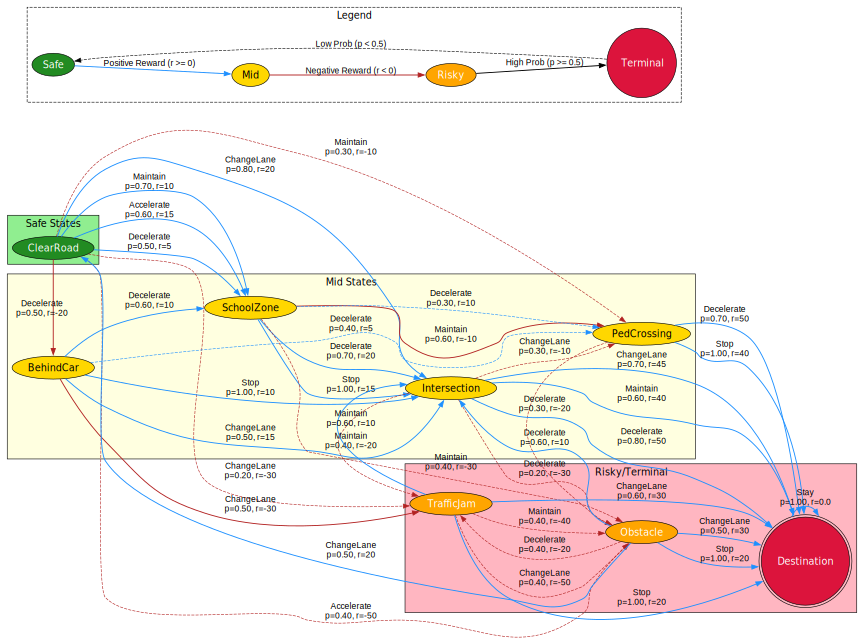

In [14]:
theta = 1e-3
inf_gamma = 0.9
start_state = 'ClearRoad'  # General starting point
vehicle_mdp = MDP(states, actions_dict, transition_probs, rewards, gamma=1.0, horizon=100, terminal_states=terminal_states) # Create MDP (gamma=1.0 for finite)
results = compare_algorithms(vehicle_mdp, start_state, theta, inf_gamma)

for key, value in results.items():
    if isinstance(value, dict):
        print(f'\n{key}:')
        for metric, result in value.items():
            print(f'- {metric}: {result}')
    else: print(f'{key}: {value}')
vehicle_mdp.draw_state_diagram(size='12', show_legend=True)

# Scenario – 2: Urban Traffic Management for a Smart City

In [15]:
states = ['BusyIntersection', 'PedestrianCrowd', 'ConstructionZone', 'EventCongestion', 'QuietResidential', 'MixedTraffic', 'OptimalFlow', 'Gridlock']
terminal_states = ['OptimalFlow', 'Gridlock']
actions_dict = {
    'BusyIntersection': ['AdjustLights', 'SuggestRoutes', 'DeployOfficers'],
    'PedestrianCrowd': ['AdjustLights', 'IncreaseTransit', 'DeployOfficers'],
    'ConstructionZone': ['SuggestRoutes', 'DeployOfficers'],
    'EventCongestion': ['SuggestRoutes', 'IncreaseTransit', 'DeployOfficers'],
    'QuietResidential': ['AdjustLights', 'IncreaseTransit'],
    'MixedTraffic': ['AdjustLights', 'SuggestRoutes', 'IncreaseTransit'],
    'OptimalFlow': ['Stay'],
    'Gridlock': ['Stay']
}
transition_probs = { # The scenario describes that: "It knows that each choice will have a clear result, without any uncertainties"
    'BusyIntersection': {  # Therefore, I will define Deterministic Transitions here: P=1 to one s' per s,a, forward to terminals
        'AdjustLights': {'MixedTraffic': 1.0},
        'SuggestRoutes': {'QuietResidential': 1.0},
        'DeployOfficers': {'PedestrianCrowd': 1.0}
    },
    'PedestrianCrowd': {
        'AdjustLights': {'MixedTraffic': 1.0},
        'IncreaseTransit': {'OptimalFlow': 1.0},
        'DeployOfficers': {'EventCongestion': 1.0}
    },
    'ConstructionZone': {
        'SuggestRoutes': {'QuietResidential': 1.0},
        'DeployOfficers': {'MixedTraffic': 1.0}
    },
    'EventCongestion': {
        'SuggestRoutes': {'ConstructionZone': 1.0},
        'IncreaseTransit': {'OptimalFlow': 1.0},
        'DeployOfficers': {'Gridlock': 1.0}
    },
    'QuietResidential': {
        'AdjustLights': {'OptimalFlow': 1.0},
        'IncreaseTransit': {'MixedTraffic': 1.0}
    },
    'MixedTraffic': {
        'AdjustLights': {'OptimalFlow': 1.0},
        'SuggestRoutes': {'BusyIntersection': 1.0},
        'IncreaseTransit': {'PedestrianCrowd': 1.0}
    },
    'OptimalFlow': {
        'Stay': {'OptimalFlow': 1.0}
    },
    'Gridlock': {
        'Stay': {'Gridlock': 1.0}
    }
}
rewards = { # Deterministic, positive for good progress
    'BusyIntersection': {
        'AdjustLights': {'MixedTraffic': 20},
        'SuggestRoutes': {'QuietResidential': 10},
        'DeployOfficers': {'PedestrianCrowd': -10}
    },
    'PedestrianCrowd': {
        'AdjustLights': {'MixedTraffic': 15},
        'IncreaseTransit': {'OptimalFlow': 50},
        'DeployOfficers': {'EventCongestion': -20}
    },
    'ConstructionZone': {
        'SuggestRoutes': {'QuietResidential': 10},
        'DeployOfficers': {'MixedTraffic': 20}
    },
    'EventCongestion': {
        'SuggestRoutes': {'ConstructionZone': -30},
        'IncreaseTransit': {'OptimalFlow': 40},
        'DeployOfficers': {'Gridlock': -50}
    },
    'QuietResidential': {
        'AdjustLights': {'OptimalFlow': 30},
        'IncreaseTransit': {'MixedTraffic': 10}
    },
    'MixedTraffic': {
        'AdjustLights': {'OptimalFlow': 40},
        'SuggestRoutes': {'BusyIntersection': -20},
        'IncreaseTransit': {'PedestrianCrowd': -10}
    },
    'OptimalFlow': {
        'Stay': {'OptimalFlow': 0.0}
    },
    'Gridlock': {
        'Stay': {'Gridlock': 0.0}
    }
}

Finite Value Iteration: Would converge at h=100 if no horizon (delta < 0.001)
Finite Policy Iteration: Converged after 6 iterations (policy stable)
Finite Value Diff: 0.0
Finite Policy Diff: 0.0

Finite Value Iteration:
- Time: 0.00651240348815918
- Conv Step (delta < theta): 100
- Avg Reward: 40.0
- Value Function (at H): {'BusyIntersection': 305.0, 'PedestrianCrowd': 300.0, 'ConstructionZone': 305.0, 'EventCongestion': 270.0, 'QuietResidential': 295.0, 'MixedTraffic': 285.0, 'OptimalFlow': 0.0, 'Gridlock': 0.0}
- Policy (at H): {'BusyIntersection': {'AdjustLights': 1.0}, 'PedestrianCrowd': {'AdjustLights': 1.0}, 'ConstructionZone': {'DeployOfficers': 1.0}, 'EventCongestion': {'SuggestRoutes': 1.0}, 'QuietResidential': {'IncreaseTransit': 1.0}, 'MixedTraffic': {'IncreaseTransit': 1.0}}

Finite Policy Iteration:
- Time: 0.07049560546875
- Iters to Stable: 6
- Avg Reward: 40.0
- Value Function (at H): {'BusyIntersection': 305.0, 'PedestrianCrowd': 300.0, 'ConstructionZone': 305.0, 'Even

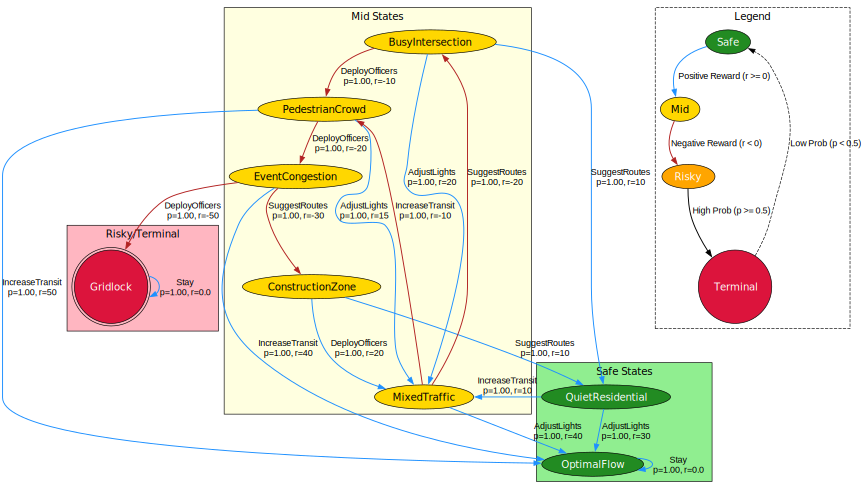

In [16]:
theta = 1e-3
inf_gamma = 0.9
start_state = 'EventCongestion'  # General starting point
traffic_mdp = MDP(states, actions_dict, transition_probs, rewards, gamma=1.0, horizon=100, terminal_states=terminal_states) # Create MDP (gamma=1.0 for finite)
# results = compare_algorithms(traffic_mdp, start_state, theta, inf_gamma, include_inf=False) # The infinite might not converge with gamma very close to 1
results = compare_algorithms(traffic_mdp, start_state, theta, inf_gamma, include_inf=True)

for key, value in results.items():
    if isinstance(value, dict):
        print(f'\n{key}:')
        for metric, result in value.items():
            print(f'- {metric}: {result}')
    else: print(f'{key}: {value}')
traffic_mdp.draw_state_diagram(rankdir='TD', size='12', show_legend=True)